# ALD - TME 13: Physics-Informed Neural Networks (PINNs)


# ALD - TME 13: 基于物理的神经网络（PINNs）

In [ ]:
import torch
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from contextlib import contextmanager
from pathlib import Path
import subprocess
from functools import partial


# CUDA support
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

np.random.seed(1234)


## As a case study, we will apply PINNs on the Burgers equations, following this PDE:

[From Wikipedia](https://en.wikipedia.org/wiki/Burgers%27_equation)

> Burgers' equation or Bateman-Burgers equation is a fundamental partial differential equation and convection-diffusion equation occurring in various areas of applied mathematics, such as fluid mechanics, nonlinear acoustics, gas dynamics, and traffic flow. The equation was first introduced by Harry Bateman in 1915 and later studied by Johannes Martinus Burgers in 1948.

The equation is as follows

$$\frac{\partial u(x,t)}{\partial t} + a ~ u(x,t)  ~ \frac{\partial u(x,t)}{\partial x} - \nu  ~  \frac{\partial^2 u(x,t)}{\partial x^2} =0$$
where $u(x,t)$ is the field (e.g. speed of the fluid at the location $x$ and time $t$).
We will get the solution of this PDE with  the friction coefficient setup to $\nu=\frac{0.01}{\pi}$, and $a=1.0$

**In PINNs, wa want to train a parametric data-driven model $f_{\theta}(x,t)$ to approximate $u(x,t)$ at any (x,t) position.**

## 作为一个案例研究，我们将基于 Burgers 方程应用 PINNs，具体的偏微分方程（PDE）如下：

[来自维基百科](https://en.wikipedia.org/wiki/Burgers%27_equation)

> Burgers 方程或 Bateman-Burgers 方程是一个基本的偏微分方程，也是一个对流-扩散方程，出现在应用数学的多个领域，例如流体力学、非线性声学、气体动力学以及交通流量研究。该方程最初由 Harry Bateman 于 1915 年提出，随后在 1948 年由 Johannes Martinus Burgers 进一步研究。

方程形式为：

$$\frac{\partial u(x,t)}{\partial t} + a ~ u(x,t)  ~ \frac{\partial u(x,t)}{\partial x} - \nu  ~  \frac{\partial^2 u(x,t)}{\partial x^2} =0$$

其中，$u(x,t)$ 是场变量（例如，位于位置 $x$ 和时间 $t$ 的流体速度）。  
我们将通过设置摩擦系数 $\nu=\frac{0.01}{\pi}$ 和 $a=1.0$ 来求解此偏微分方程。

**在 PINNs 中，我们希望训练一个基于参数的数据驱动模型 $f_{\theta}(x,t)$，以在任意位置 $(x,t)$ 近似 $u(x,t)$。**

# Loading the data

In [ ]:
if not Path("burgers_shock.mat").is_file():
    subprocess.run(
        ["wget", "https://thome.isir.upmc.fr/classes/RLD/PINNs/data/burgers_shock.mat"]
    )


data = scipy.io.loadmat("./burgers_shock.mat")

t = torch.Tensor(data["t"].flatten())
x = torch.Tensor(data["x"].flatten())
Exact = torch.Tensor(data["usol"]).T
extent = [t.min(), t.max(), x.min(), x.max()]

print(f"t: {t.shape}")
print(f"x: {x.shape}")
print(f"Exact: {Exact.shape}")

t: torch.Size([100])
x: torch.Size([256])
Exact: torch.Size([100, 256])


## **Plot the evolution of the solution u(x,t) over time.**

In the figure below, we plot the evolution of $u$ (given in `Exact`) over time (given in `t`, x-axis) and $x$ (given in `x`, y-axis).

## **绘制解 $ u(x,t) $ 随时间的演变图**

在下图中，我们绘制了 $ u $（在“Exact”中给出）随时间 $ t $（x 轴）和位置 $ x $（y 轴）的演变过程。

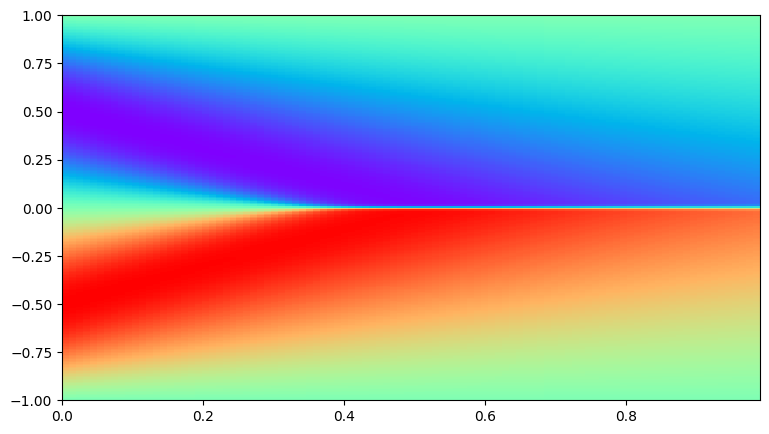

In [ ]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
h = ax.imshow(
    Exact.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)


# Exercice 1: learning the solution with physics-informed constraints

In PINNs, we want to train a parametric data-driven model $f_{\theta}(x,t)$ to approximate $u(x,t)$ at any (x,t) position. PINNs combine two losses during training:

## Supervised loss

A supervised loss, where we have $N_u$ labeled points $\left\{(x_i,t_i,u_i)\right\}_{i \in \left\{ 1 ; N \right\}}$. We use the standard MSE loss between the model prediction $f_{\theta}(x_i,t_i)$ and the ground truth $u_i$:
$$l_u(\theta) = \frac{1}{N_u} \sum\limits_{i=1}^{N_u} \left[f_{\theta}(x_i,t_i)-u_i(x_i,t_i)\right]^2$$
In the first exercice, we randomly sample $N_u=100$ points **in the boundary layer** - $(x_{min},t)$, $(x_{max},t)$ and in initial condtions $(x,0)$.

## Unsupervised loss

For the unsupervised loss, we randomly sample $N_f$ points in the $(x,t)$ interval, and enforce the learned function $f_{\theta}$ to fulfill the PDE. Let us define
$$h(f_{\theta}(x,t)) = \frac{\partial f_{\theta}(x,t)}{\partial t} + f_{\theta}(x,t) \frac{\partial f_{\theta}(x,t)}{\partial x} - \nu \frac{\partial^2 f_{\theta}(x,t)}{\partial x^2}$$
We can define the following unsupervised loss
$$l_f(\theta) = \frac{1}{N_f} \sum\limits_{i=1}^{N_f} \left[h_{\theta}(x_i,t_i)\right]^2 $$

The final loss in PINNs will be a combination of both supervised and unsupervised  losses:

$$
\mathcal{L}(\theta) = \lambda_u l_u(\theta) + \lambda_fl_f(\theta)
$$

# 练习 1：通过基于物理的约束学习解

在 PINNs 中，我们希望训练一个基于参数的数据驱动模型 $f_{\theta}(x,t)$，以在任意位置 $(x,t)$ 近似 $u(x,t)$。PINNs 在训练过程中结合了两种损失：

## 监督损失（Supervised loss）

监督损失指的是我们在 $N_u$ 个带标签的数据点 $\left\{(x_i,t_i,u_i)\right\}_{i \in \left\{ 1 ; N \right\}}$ 上训练模型。通过计算模型预测值 $f_{\\theta}(x_i,t_i)$ 和真实值 $u_i$ 之间的均方误差（MSE），定义损失为：

$$l_u(\theta) = \frac{1}{N_u} \sum\limits_{i=1}^{N_u} \left[f_{\theta}(x_i,t_i)-u_i(x_i,t_i)\right]^2$$

在第一个练习中，我们随机采样 $N_u=100$ 个点，**这些点位于边界层**（即 $(x_{min},t)$ 和 $(x_{max},t)$）以及初始条件 $(x,0)$。

## 无监督损失（Unsupervised loss）

无监督损失是通过随机采样 $(x,t)$ 区间内的 $N_f$ 个点，并强制学习到的函数 $f_{\\theta}$ 满足给定的偏微分方程（PDE）。定义如下：

$$h(f_{\theta}(x,t)) = \frac{\partial f_{\theta}(x,t)}{\partial t} + f_{\theta}(x,t) \frac{\partial f_{\theta}(x,t)}{\partial x} - \nu \frac{\partial^2 f_{\theta}(x,t)}{\partial x^2}$$

相应的无监督损失可以定义为：

$$l_f(\theta) = \frac{1}{N_f} \sum\limits_{i=1}^{N_f} \left[h_{\theta}(x_i,t_i)\right]^2 $$

## 最终损失

在 PINNs 中，最终的损失函数是监督损失和无监督损失的组合：

$$
\mathcal{L}(\theta) = \lambda_u l_u(\theta) + \lambda_fl_f(\theta)
$$

## **1.1) Collect labeled data and unlabeled physics-informed constraint data.**

In the code below, you will collect $N_u$ supervised data points and $N_f$ unsupervised ones. It should set the following values:

- `X_u_train` is a matrix $N_u \times 2$ (dimensions = $x$ and $t$)
- `u_train` is a vector with $u(x,t)$ values for $(x,t)$ couples in `X_u_train`
- `X_f_train` is a matrix $N_f \times 2$ (dimensions = $x$ and $t$)

## **1.1) 收集有标签的数据和无标签的基于物理的约束数据**

在下面的代码中，您将收集 $N_u$ 个监督数据点和 $N_f$ 个无监督数据点。需要设置以下内容：

- `X_u_train` 是一个矩阵，尺寸为 $N_u \times 2$（包含 $x$ 和 $t$ 两个维度）。
- `u_train` 是一个向量，存储了 `X_u_train` 中 $(x,t)$ 对应的 $u(x,t)$ 值。
- `X_f_train` 是一个矩阵，尺寸为 $N_f \times 2$（包含 $x$ 和 $t$ 两个维度）。

In [ ]:
# Creates a grid from x and t, of shape (time x position)
T, X = torch.meshgrid(t, x)

assert len(X) == len(t)
assert Exact.shape == T.shape, f"{Exact.shape} vs {T.shape}"

# Shape (N, 2)
X_star = torch.hstack((X.flatten().reshape(-1, 1), T.flatten().reshape(-1, 1)))

# u(x,t) for X_star
u_star = Exact.flatten()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
###### Labeled points

N_u = 100  # Number of points to compute the prediction loss (MSE_u)

# À compléter...
# assert False, 'Code non implémenté'
def boundary_view(tensor: torch.Tensor):
    return torch.vstack(
        tuple(t.reshape(-1, 1) for t in (tensor[0, :], tensor[:, 0], tensor[:, -1]))
    )

init_boundary_x = boundary_view(X)
init_boundary_t = boundary_view(T)
init_boundary_solutions = boundary_view(Exact)

idxu = np.random.choice(len(init_boundary_solutions), N_u, replace=False)

x_train = init_boundary_x[idxu]
t_train = init_boundary_t[idxu]
u_train = init_boundary_solutions[idxu]

# Some checks...

assert x_train.shape == (N_u, 1), f"{x_train.shape} != {(N_u, 1)}"
assert t_train.shape == (N_u, 1), f"{t_train.shape} != {(N_u, 1)}"
assert u_train.shape == (N_u, 1), f"{u_train.shape} != {(N_u, 1)}"
assert (
    (t_train == 0) | (x_train == float(x.min())) | (x_train == float(x.max()))
).all(), "Some points do not belong to boundary"

In [ ]:
###### Unlabeled points

N_f = 10000  # Number of points to apply the constraint

# À compléter...
# assert False, 'Code non implémenté'
idxf = np.random.choice(X_star.shape[0], N_f, replace=False)

x_train_f = X_star[idxf, 0:1]
t_train_f = X_star[idxf, 1:2]


# Some checks...

assert x_train_f.shape == (N_f, 1), f"{x_train_f.shape} != {(N_f, 1)}"
assert t_train_f.shape == (N_f, 1), f"{t_train_f.shape} != {(N_f, 1)}"
assert ((x_train_f >= x.min()) & (x_train_f <= x.max())).all()
assert ((t_train_f >= t.min()) & (t_train_f <= t.max())).all()


# Adds boundary points to the unsupervised data set
x_train_f = torch.vstack((x_train_f, x_train))
t_train_f = torch.vstack((t_train_f, t_train))

In [ ]:
# Let's move everything to the target device


def prepare(*tensors):
    return (torch.Tensor(t).float().to(device) for t in tensors)


# Supervised data
x_train, t_train, u_train = prepare(x_train, t_train, u_train)

# Unsupervised data
x_train_f, t_train_f = prepare(x_train_f, t_train_f)

# All data points (for plots)
x_star, t_star = prepare(*X_star.split((1, 1), dim=1))

## 1.2) Plot the selected labeled boundary and initial points.

We can now plot the selected points

## 1.2) 绘制选定的有标签边界点和初始点

现在我们可以绘制选定的点。

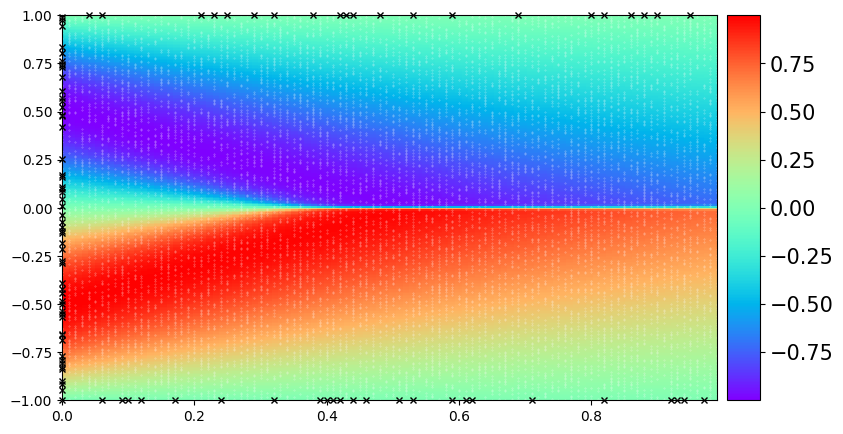

In [ ]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(
    Exact.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)

# h = ax.imshow(Exact.T, cmap='rainbow', origin='lower', aspect='auto') # Exact.T size (256,100), u(x,t) avec x[0] = -1
# plt.imshow(Exact.T[::-1,:], cmap='rainbow') # Pour avoir x = -1 en bas

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    t_train.cpu(),
    x_train.cpu(),
    "kx",
    label="Data (%d points)" % (u_train.shape[0]),
    markersize=4,  # marker size doubled
    clip_on=False,
    alpha=1.0,
)

ax.plot(
    t_train_f.cpu(),
    x_train_f.cpu(),
    "wx",
    markersize=1,  # marker size doubled
    clip_on=False,
    alpha=0.2,
)

plt.show()

## 1.3) Write the code of for $f_\theta$

We will use a simple fully connected neural network (NN) as $f_{\theta}$.
Use *e.g.* 8 hidden layers with tanh activation functions.



## 1.3) 编写 $f_\theta$ 的代码

我们将使用一个简单的全连接神经网络（NN）作为 $f_\theta$。  
例如，使用具有 8 个隐藏层并带有 tanh 激活函数的网络。

In [ ]:
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(torch.nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                self.layers.append(torch.nn.Tanh())

    def forward(self, x, t):
        inputs = torch.hstack((x, t))
        for layer in self.layers:
            inputs = layer(inputs)
        return inputs

    @contextmanager
    def eval_mode(self):
        training = self.training
        if training:
            self.eval()
        yield
        if training:
            self.train()

    def predict(self, x: torch.Tensor, t: torch.Tensor):
        with self.eval_mode():
            u = self(x, t)
            u = u.detach().cpu().numpy()
            return u

layers = [2] + [20]*8 + [1]

dnn = DNN(layers)

dnn.to(device)
assert dnn(x_train[:5], t_train[:5]).shape == (
    5,
    1,
), f"{dnn(x_train[5:], t_train[5:]).shape}"

In [ ]:
print(dnn)

DNN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): Tanh()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): Tanh()
    (14): Linear(in_features=20, out_features=20, bias=True)
    (15): Tanh()
    (16): Linear(in_features=20, out_features=1, bias=True)
  )
)



## 1.4) Write the code of the PhysicsInformedNN.

We will now implement the core class of this practical: the `PhysicsInformedNN`.

It will be predict the fonction $f_{\theta}(x,t)$, and the $h(f_{\theta}(x,t))$, where the latter is defined as:

$$h(f_{\theta}(x,t)) = \frac{\partial f_{\theta}(x,t)}{\partial t} + f_{\theta}(x,t) \frac{\partial f_{\theta}(x,t)}{\partial x} - \nu \frac{\partial^2 f_{\theta}(x,t)}{\partial x^2}$$

Note that you need to use [`torch.autograd.grad`](https://pytorch.org/docs/stable/generated/torch.autograd.grad.html) to compute derivatives and second order derivatives.

The `forward` function will return both $f_{\theta}(x,t)$ and $h(f_{\theta}(x,t))$.


## 1.4) 编写 `PhysicsInformedNN` 的代码

我们现在将实现本实践的核心类：`PhysicsInformedNN`。

该类将预测函数 $f_{\theta}(x,t)$ 和 $h(f_{\theta}(x,t))$，其中 $h(f_{\theta}(x,t))$ 定义为：

$$h(f_{\theta}(x,t)) = \frac{\partial f_{\theta}(x,t)}{\partial t} + f_{\theta}(x,t) \frac{\partial f_{\theta}(x,t)}{\partial x} - \nu \frac{\partial^2 f_{\theta}(x,t)}{\partial x^2}$$

需要注意的是，你需要使用 [`torch.autograd.grad`](https://pytorch.org/docs/stable/generated/torch.autograd.grad.html) 来计算一阶导数和二阶导数。

`forward` 函数将返回 $f_{\theta}(x,t)$ 和 $h(f_{\theta}(x,t))$。

In [ ]:
# the physics-guided neural network
class PhysicsInformedNN(torch.nn.Module):
    def __init__(self, dnn: DNN, nu: float):
        super().__init__()

        # nu = viscosity
        self.nu = nu
        self.dnn = dnn



    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # À compléter...
        # assert False, 'Code non implémenté'
        x.requires_grad_(True)
        t.requires_grad_(True)

        # f_theta
        u = self.dnn(x, t)

        u_x = torch.autograd.grad(
            outputs = u,
            inputs = x,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
        )[0]

        u_t = torch.autograd.grad(
            outputs = u,
            inputs = t,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
        )[0]

        u_xx = torch.autograd.grad(
            outputs = u_x,
            inputs = x,
            grad_outputs = torch.ones_like(u_x),
            create_graph = True,
        )[0]

        f = u_t + u * u_x - self.nu * u_xx

        return u, f

    @contextmanager
    def eval_mode(self):
        training = self.training
        if training:
            self.eval()
        yield
        if training:
            self.train()

    def predict(self, x: torch.Tensor, t: torch.Tensor):
        with self.eval_mode():
            u, f = self(x, t)
            u = u.detach().cpu().numpy()
            f = f.detach().cpu().numpy()
            return u, f


model = PhysicsInformedNN(dnn, 0.01 / np.pi).to(device)

u, f = model(x_train[:5], t_train[:5])
assert u.shape == (5, 1) and f.shape == (5, 1)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


## 1.5) Write the code of the pinns_loss to train the PhysicsInformedNN

The `pinss_loss` function should return

- The global loss $\lambda_u L_u + \lambda_f L_f$
- The supervised loss $l_u(\theta) = \frac{1}{N_u} \sum\limits_{i=1}^{N_u} \left[f_{\theta}(x_i,t_i)-u_i(x_i,t_i)\right]^2$
- The unsupervised loss $l_f(\theta) = \frac{1}{N_f} \sum\limits_{i=1}^{N_f} \left[h_{\theta}(x_i,t_i)\right]^2 $

The final loss in PINNs will be a combination of both supervised and unsupervised  losses:

$$
\mathcal{L}(\theta) = \lambda_u l_u(\theta) + \lambda_fl_f(\theta)
$$


## 1.5) 编写 `pinns_loss` 的代码以训练 `PhysicsInformedNN`

`pinns_loss` 函数需要返回以下内容：

- 全局损失：$\lambda_u L_u + \lambda_f L_f$  
- 监督损失：$l_u(\theta) = \frac{1}{N_u} \sum\limits_{i=1}^{N_u} \left[f_{\theta}(x_i,t_i)-u_i(x_i,t_i)\right]^2$
- 无监督损失：$l_f(\theta) = \frac{1}{N_f} \sum\limits_{i=1}^{N_f} \left[h_{\theta}(x_i,t_i)\right]^2 $

在 PINNs 中，最终的损失是监督损失和无监督损失的组合：

$$  
\mathcal{L}(\theta) = \lambda_u l_u(\theta) + \lambda_f l_f(\theta)  
$$

In [ ]:
def pinns_loss(
    u_pred: torch.Tensor,
    u_target: torch.Tensor,
    f_pred: torch.Tensor,
    lambda_u=1.0,
    lambda_f=1.0,
):
    # À compléter...
    # assert False, 'Code non implémenté'
    loss_u = torch.mean((u_pred - u_target)**2)

    loss_f = torch.mean(f_pred**2)

    loss = lambda_u * loss_u + lambda_f * loss_f

    return loss, loss_u, loss_f

## **1.6) Train the model!**

You can use a standard Adam optimizer, or to speed-up convergence a LBFGS. In case of LBFGS, you need to use a closure when calling the step method. This closure will do the forward, and optionally the forward pass:

```python
def loss_closure():
  if torch.is_grad_enabled():
    optimizer.zero_grad()

  loss = ...

  if loss.requires_grad:
    loss.backward()

  return loss

optimizer.step(loss_closure)
```

This closure can be used also when using `Adam` or any other optimizer.


## **1.6) 训练模型！**

你可以使用标准的Adam优化器，或者为了加速收敛使用LBFGS优化器。如果使用LBFGS，你需要在调用`step`方法时使用一个闭包（closure）。这个闭包将执行前向计算，并可选地执行前向传递：

```python
def loss_closure():
  if torch.is_grad_enabled():
    optimizer.zero_grad()

  loss = ...

  if loss.requires_grad:
    loss.backward()

  return loss

optimizer.step(loss_closure)
```

这个闭包也可以在使用`Adam`或任何其他优化器时使用。

In [ ]:
# À compléter...
# assert False, 'Code non implémenté'

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

num_epochs = 2000
lambda_u = 1.0
lambda_f = 1.0

def loss_closure():
    if torch.is_grad_enabled():
        optimizer.zero_grad()

    u_pred, f_pred = model(x_train, t_train)[0], model(x_train_f, t_train_f)[1]
    loss, loss_u, loss_f = pinns_loss(u_pred, u_train, f_pred, lambda_u, lambda_f)

    if loss.requires_grad:
        loss.backward()
    return loss

for epoch in range(num_epochs):

    loss = loss_closure()

    optimizer.step(loss_closure)

    if epoch % 100 == 0 or epoch == num_epochs - 1:
        loss = loss.item()
        print(f"Epoch {epoch}: Total Loss = {loss:.6f}")

Epoch 0: Total Loss = 0.274430
Epoch 100: Total Loss = 0.150461
Epoch 200: Total Loss = 0.086469
Epoch 300: Total Loss = 0.064841
Epoch 400: Total Loss = 0.053491
Epoch 500: Total Loss = 0.042178
Epoch 600: Total Loss = 0.036617
Epoch 700: Total Loss = 0.050594
Epoch 800: Total Loss = 0.022005
Epoch 900: Total Loss = 0.019818
Epoch 1000: Total Loss = 0.018526
Epoch 1100: Total Loss = 0.017819
Epoch 1200: Total Loss = 0.020860
Epoch 1300: Total Loss = 0.015694
Epoch 1400: Total Loss = 0.015835
Epoch 1500: Total Loss = 0.014291
Epoch 1600: Total Loss = 0.014622
Epoch 1700: Total Loss = 0.012296
Epoch 1800: Total Loss = 0.036365
Epoch 1900: Total Loss = 0.011725
Epoch 1999: Total Loss = 0.010351


In [ ]:
optimizer = torch.optim.LBFGS(
    model.parameters(),
    lr = 1.0,
    max_iter = 50000,
    max_eval = 50000,
    tolerance_grad = 1e-7,
    tolerance_change = 1e-9,
    history_size = 50,
    line_search_fn = "strong_wolfe",
)

num_epochs = 1
lambda_u = 1.0
lambda_f = 1.0

for epoch in range(num_epochs):

    optimizer.step(loss_closure)

    loss = loss_closure().item()
    print(f"Epoch {epoch}: Total Loss = {loss:.6f}")

Epoch 0: Total Loss = 0.000041


## **1.7) Asses the performances of the model!**

- Visually assess the prediction on the  $(x,t)$ plane
- Compute the mean prediction error, and the error in the $(x,t)$ plane
- the prediction error over time slices at $t=0$, $t=25$, $t=50$, $t=75$

## **1.7) 评估模型的性能！**

- 通过可视化评估在 $(x,t)$ 平面上的预测
- 计算平均预测误差，以及在 $(x,t)$ 平面上的误差
- 计算在时间切片 $t=0$、$t=25$、$t=50$、$t=75$ 时的预测误差

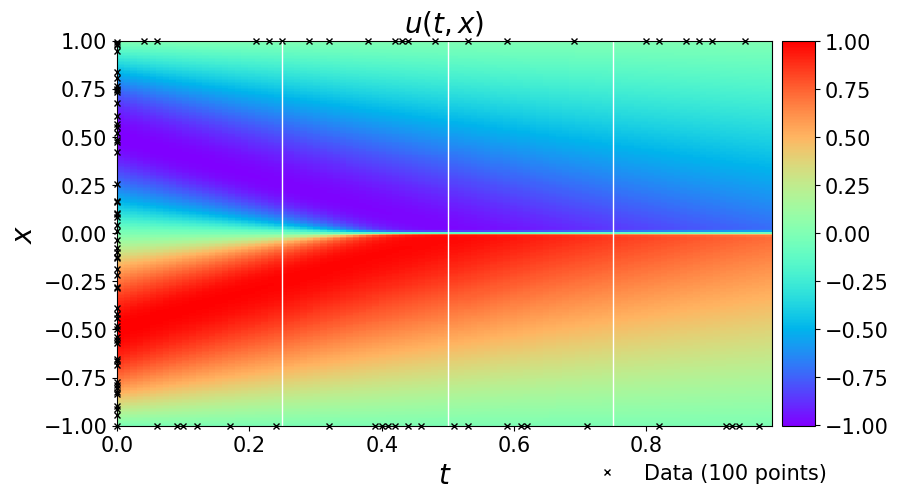

In [ ]:
####### Visually assess the prediction on the  $(x,t)$ plane

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

u_pred, f_pred = model.predict(x_star, t_star)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method="cubic")

h = ax.imshow(
    U_pred.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    t_train.cpu().detach().numpy(),
    x_train.cpu().detach().numpy(),
    "kx",
    label="Data (%d points)" % (u_train.shape[0]),
    markersize=4,  # marker size doubled
    clip_on=False,
    alpha=1.0,
)

line = np.linspace(x.min(), x.max(), 2)[:, None]
ax.plot(t[25] * np.ones((2, 1)), line, "w-", linewidth=1)
ax.plot(t[50] * np.ones((2, 1)), line, "w-", linewidth=1)
ax.plot(t[75] * np.ones((2, 1)), line, "w-", linewidth=1)

ax.set_xlabel("$t$", size=20)
ax.set_ylabel("$x$", size=20)
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.9, -0.05),
    ncol=5,
    frameon=False,
    prop={"size": 15},
)
ax.set_title("$u(t,x)$", fontsize=20)  # font size doubled
ax.tick_params(labelsize=15)

plt.show()

Error u: 3.486785e-02


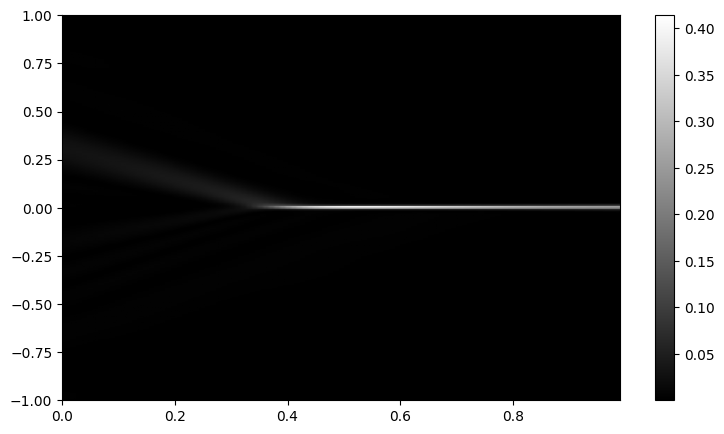

In [ ]:
####### Compute the mean prediction error
error_u = np.linalg.norm(u_star - u_pred.flatten(), 2) / np.linalg.norm(u_star, 2)
print("Error u: %e" % (error_u))

# U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

####### Error in the $(x,t)$ planefig = plt.figure(figsize=(9, 5))
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
h = ax.imshow(Error.T, extent=extent, origin="lower", aspect="auto", cmap="gray")
cbar = fig.colorbar(h)
plt.show()

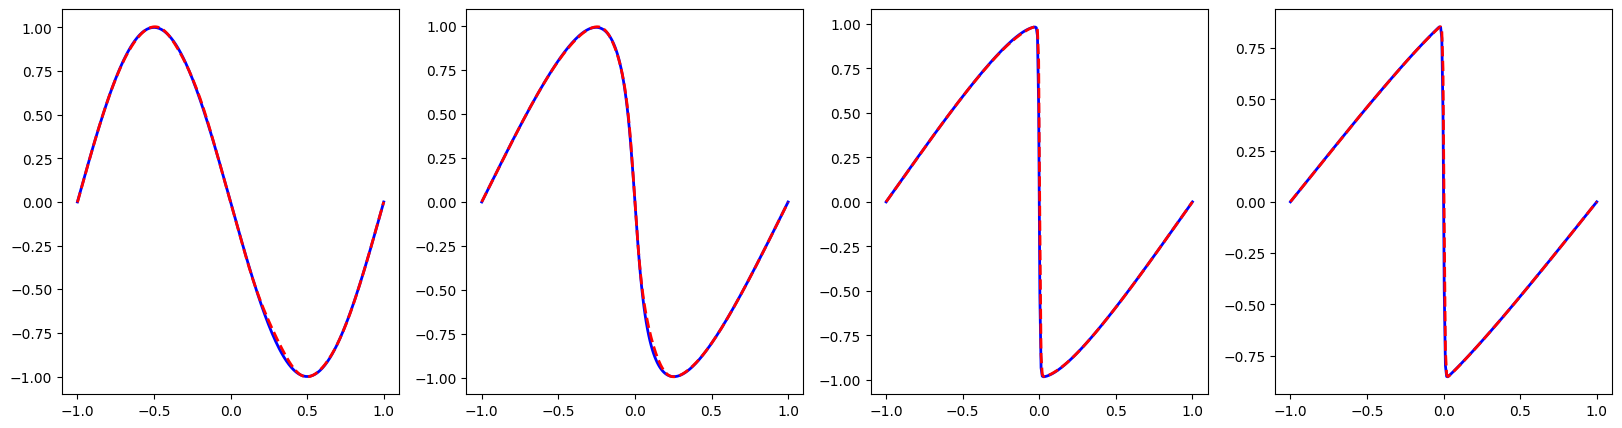

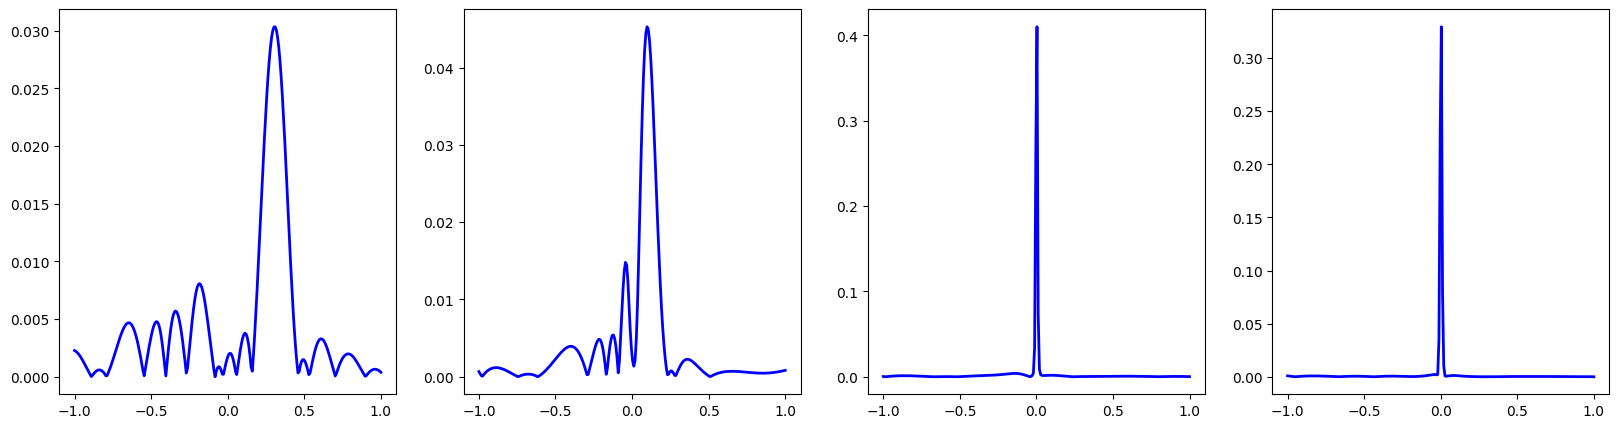

In [ ]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, Exact[0, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[0, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(142)
ax.plot(x, Exact[25, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[25, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(143)
ax.plot(x, Exact[50, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[50, :], "r--", linewidth=2, label="Prediction")


ax = fig.add_subplot(144)
ax.plot(x, Exact[75, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[75, :], "r--", linewidth=2, label="Prediction")

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, Error[0, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(142)
ax.plot(x, Error[25, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(143)
ax.plot(x, Error[50, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(144)
ax.plot(x, Error[75, :], "b-", linewidth=2, label="Erreur")

# print(Error[75,100:150])

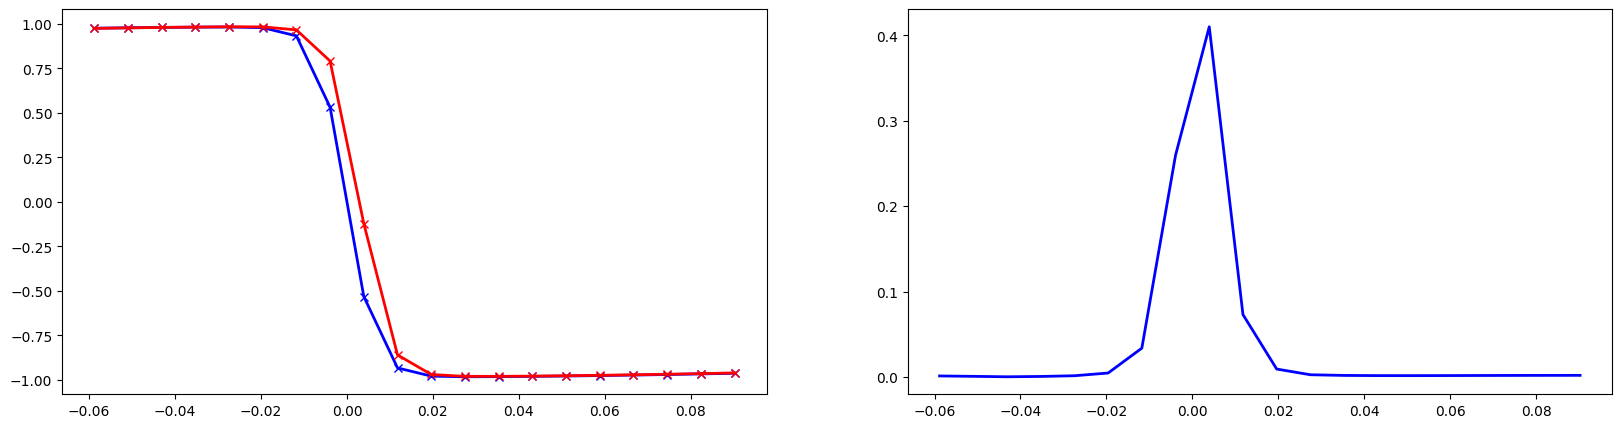

In [ ]:
############# Close-up on slide at t=50
index = 50
min = 120
max = 140
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(121)
ax.plot(x[min:max], Exact[index, min:max], "b-x", linewidth=2, label="Exact")
ax.plot(x[min:max], U_pred[index, min:max], "r-x", linewidth=2, label="Prediction")

ax = fig.add_subplot(122)
ax.plot(x[min:max], Error[index, min:max], "b-", linewidth=2, label="Exact")

## **1.8) Train a prediction model without adding any constraint (fully data-driven model). Conclude.**

## **1.8) 训练一个没有添加任何约束的预测模型（完全数据驱动的模型）。总结。**

In [ ]:
# À compléter...
# assert False, 'Code non implémenté'

layers = [2] + 8 * [20] + [1]
dnn_simple = DNN(layers).to(device)
criterion = torch.nn.MSELoss()

def loss_closure_simple():
    if torch.is_grad_enabled():
        optimizer.zero_grad()

    u_pred = dnn_simple(x_train, t_train)
    loss = criterion(u_pred, u_train)

    if loss.requires_grad:
        loss.backward()
    return loss

# Adam 开始训练
optimizer = torch.optim.Adam(dnn_simple.parameters(), lr = 1e-3)
num_epochs = 2000

for epoch in range(num_epochs):

    loss = loss_closure_simple()

    optimizer.step(loss_closure_simple)

    if epoch % 100 == 0 or epoch == num_epochs - 1:
        loss = loss.item()
        print(f"Epoch {epoch}: Total Loss = {loss:.6f}")


Epoch 0: Total Loss = 0.253792
Epoch 100: Total Loss = 0.123746
Epoch 200: Total Loss = 0.004585
Epoch 300: Total Loss = 0.000210
Epoch 400: Total Loss = 0.000087
Epoch 500: Total Loss = 0.000067
Epoch 600: Total Loss = 0.000117
Epoch 700: Total Loss = 0.000031
Epoch 800: Total Loss = 0.000014
Epoch 900: Total Loss = 0.000015
Epoch 1000: Total Loss = 0.000014
Epoch 1100: Total Loss = 0.000010
Epoch 1200: Total Loss = 0.000135
Epoch 1300: Total Loss = 0.000006
Epoch 1400: Total Loss = 0.000006
Epoch 1500: Total Loss = 0.000091
Epoch 1600: Total Loss = 0.000019
Epoch 1700: Total Loss = 0.000032
Epoch 1800: Total Loss = 0.000479
Epoch 1900: Total Loss = 0.000049
Epoch 1999: Total Loss = 0.000491


In [ ]:
optimizer = torch.optim.LBFGS(
    dnn_simple.parameters(),
    lr = 1.0,
    max_iter = 50000,
    tolerance_grad = 1e-7,
)

# LBFGS 开始训练
dnn_simple.train()

optimizer.step(loss_closure_simple)

print(f"Epoch 1 : Loss = {loss_closure_simple().item():.6f}")

Epoch 1 : Loss = 0.000003


Error u: 9.795653e-01


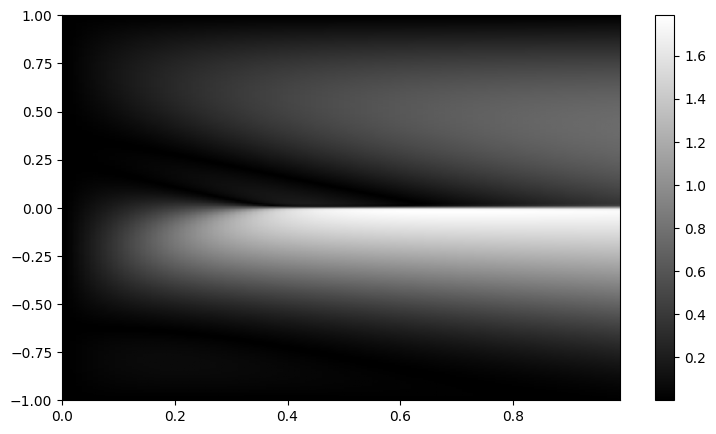

In [ ]:
####### Compute the mean prediction error
# u_pred, f_pred = model.predict(x_star, t_star)
u_pred = dnn_simple.predict(x_star, t_star)

error_u = np.linalg.norm(u_star - u_pred.flatten(), 2) / np.linalg.norm(u_star, 2)
print("Error u: %e" % (error_u))


U_pred = griddata(X_star, u_pred.flatten(), (X, T), method="cubic")
Error = np.abs(Exact - U_pred)

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
h = ax.imshow(
    Error.T,
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
    cmap="gray",
)
cbar = fig.colorbar(h)
plt.show()

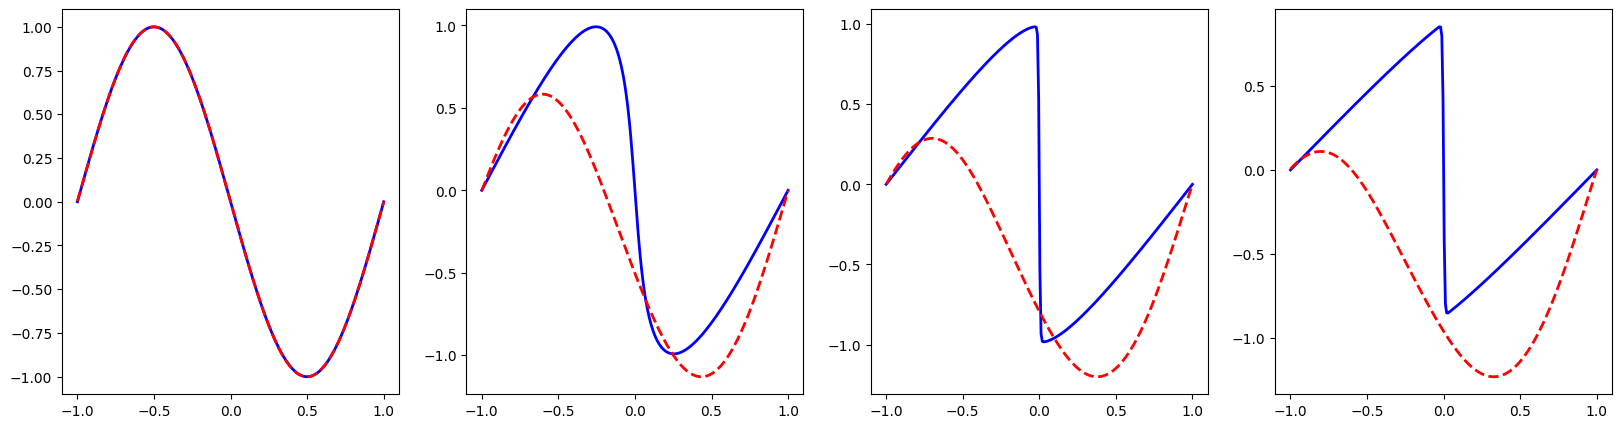

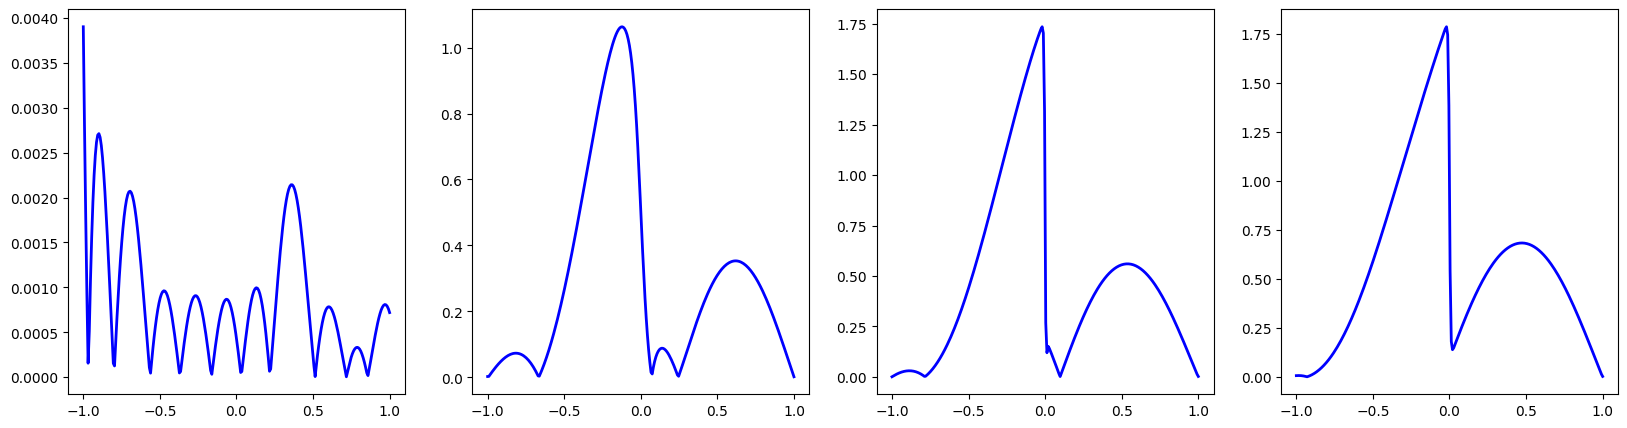

In [ ]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, Exact[0, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[0, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(142)
ax.plot(x, Exact[25, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[25, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(143)
ax.plot(x, Exact[50, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[50, :], "r--", linewidth=2, label="Prediction")


ax = fig.add_subplot(144)
ax.plot(x, Exact[75, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[75, :], "r--", linewidth=2, label="Prediction")

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, Error[0, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(142)
ax.plot(x, Error[25, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(143)
ax.plot(x, Error[50, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(144)
ax.plot(x, Error[75, :], "b-", linewidth=2, label="Erreur")


# Exercice 2: physical parameter identification with PINNs

Remind that Burgers equation are driven by the following PDE :

$$\frac{\partial u(x,t)}{\partial t} + a  ~ u(x,t) ~ \frac{\partial
u(x,t)}{\partial x} - \nu  ~ \frac{\partial^2 u(x,t)}{\partial x^2} =0$$

In the previous part, we supposed that $a$ and $\nu$ were known. In this
exercice,


**We will augment the PhysicsInformedNN to estimate the physical parameters
$\nu$ and $a$**

# 练习 2：使用 PINNs 进行物理参数识别

回顾一下，Burgers 方程由以下 PDE 驱动：

$$\frac{\partial u(x,t)}{\partial t} + a  ~ u(x,t) ~ \frac{\partial
u(x,t)}{\partial x} - \nu  ~ \frac{\partial^2 u(x,t)}{\partial x^2} =0$$

在前一部分中，我们假设 $a$ 和 $\nu$ 是已知的。在本练习中，

**我们将扩展 PhysicsInformedNN 来估计物理参数 $\nu$ 和 $a$**


## 2.1) Write the code for getting training data

We randomly sample $N_u=500$ points on the (x,t) plane on which we will apply
*both* the labeled $l_u$ and unlabeled $l_f$ losses. Note that contrary to the
previous exercise, we don't sample on the boundary.


## 2.1) 编写获取训练数据的代码

我们在 $(x,t)$ 平面上随机采样 $N_u=500$ 个点，在这些点上我们将同时应用标记的损失 $l_u$ 和未标记的损失 $l_f$。请注意，与前一个练习不同，我们不在边界上采样。

In [ ]:

# Identification de paramètres physiques
np.random.seed(1234)
N_u = 500  # Number of points to compute the prediction loss (MSE_u)

# À compléter...
# assert False, 'Code non implémenté'
def non_boundary_view(tensor: torch.Tensor):
    return torch.vstack(
        tuple(t.reshape(-1,1) for t in tensor[1:-1, 1:-1])
    )

init_non_boundary_x = non_boundary_view(X)
init_non_boundary_t = non_boundary_view(T)
init_non_boundary_solutions = non_boundary_view(Exact)

idxuf = np.random.choice(len(init_non_boundary_solutions), N_u, replace=False)

x_train_uf = init_non_boundary_x[idxuf]
t_train_uf = init_non_boundary_t[idxuf]
u_train_uf = init_non_boundary_solutions[idxuf]

assert x_train_uf.shape == (N_u, 1), f"{x_train_uf.shape}"
assert t_train_uf.shape == (N_u, 1), f"{t_train_uf.shape}"
assert u_train_uf.shape == (N_u, 1), f"{u_train_uf.shape} vs {N_u}"

x_train_uf, t_train_uf, u_train_uf = prepare(x_train_uf, t_train_uf, u_train_uf)

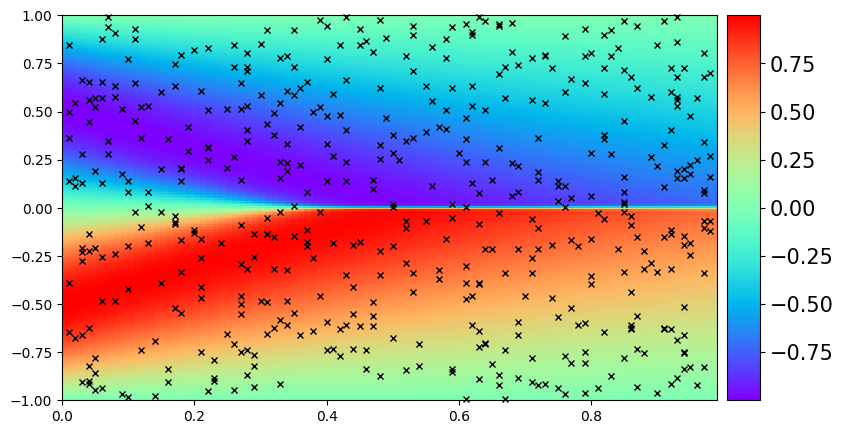

In [ ]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
h = ax.imshow(
    Exact.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=extent,
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    t_train_uf.cpu(),
    x_train_uf.cpu(),
    "kx",
    label="Data (%d points)" % (u_train.shape[0]),
    markersize=4,  # marker size doubled
    clip_on=False,
    alpha=1.0,
)

plt.show()

## 2.2) Create a new PhysicsInformedNN_ID with trainable parameters to estimate $\nu$ and $a$

## 2.2) 创建一个新的带有可训练参数的 PhysicsInformedNN_ID 来估计 $\nu$ 和 $a$

In [ ]:
# the physics-guided neural network

# À compléter...
# assert False, 'Code non implémenté'

# Physics-Informed Neural Network for parameter identification
class PhysicsInformedNN_ID(torch.nn.Module):
    def __init__(self, dnn: DNN, nu_init: float, a_init: float):
        super().__init__()

        # Initialize the trainable parameters nu and a
        self.nu = torch.nn.Parameter(torch.tensor(nu_init, dtype=torch.float32, requires_grad=True))
        self.a = torch.nn.Parameter(torch.tensor(a_init, dtype=torch.float32, requires_grad=True))

        # Neural network
        self.dnn = dnn

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # Ensure gradients are tracked for x and t
        x.requires_grad_(True)
        t.requires_grad_(True)

        # Compute f_theta
        u = self.dnn(x, t)

        # Compute partial derivatives using autograd
        u_x = torch.autograd.grad(
            outputs=u,
            inputs=x,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
        )[0]

        u_t = torch.autograd.grad(
            outputs=u,
            inputs=t,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
        )[0]

        u_xx = torch.autograd.grad(
            outputs=u_x,
            inputs=x,
            grad_outputs=torch.ones_like(u_x),
            create_graph=True,
        )[0]

        # Compute f_theta using the augmented Burgers' equation
        f = u_t + self.a * u * u_x - self.nu * u_xx

        return u, f

    @contextmanager
    def eval_mode(self):
        training = self.training
        if training:
            self.eval()
        yield
        if training:
            self.train()

    def predict(self, x: torch.Tensor, t: torch.Tensor):
        with self.eval_mode():
            u, f = self(x, t)
            u = u.detach().cpu().numpy()
            f = f.detach().cpu().numpy()
            return u, f


# Initialize the model with initial guesses for nu and a
nu_init = torch.randint(0,1)  # Example initial value for nu
a_init = torch.randint(0,1)            # Example initial value for a

model_id = PhysicsInformedNN_ID(dnn, nu_init, a_init).to(device)

# Test the model with some training data
u, f = model_id(x_train[:5], t_train[:5])
assert u.shape == (5, 1) and f.shape == (5, 1), f"{u.shape}, {f.shape}"

# Print initial values of the trainable parameters
print(f"Initial nu: {model_id.nu.item()}, Initial a: {model_id.a.item()}")


Initial nu: 0.0031830989755690098, Initial a: 1.0


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


## 2.3) Train the model

In [ ]:
# À compléter...
# assert False, 'Code non implémenté'

optimizer = torch.optim.Adam(model_id.parameters(), lr = 1e-3)

num_epochs = 5000
lambda_u = 1.0
lambda_f = 1.0

def loss_closure_id():
    if torch.is_grad_enabled():
        optimizer.zero_grad()

    u_pred, f_pred = model_id(x_train_uf, t_train_uf)
    loss, loss_u, loss_f = pinns_loss(u_pred, u_train_uf, f_pred, lambda_u, lambda_f)

    if loss.requires_grad:
        loss.backward()
    return loss

for epoch in range(num_epochs):

    loss = loss_closure_id()

    optimizer.step(loss_closure_id)

    if epoch % 100 == 0 or epoch == num_epochs - 1:
        loss = loss.item()
        print(f"Epoch {epoch}: Total Loss = {loss:.6f}")


Epoch 0: Total Loss = 0.000004
Epoch 100: Total Loss = 0.000059
Epoch 200: Total Loss = 0.000006


KeyboardInterrupt: 

In [ ]:
optimizer = torch.optim.LBFGS(
    model_id.parameters(),
    lr = 1.0,
    max_iter = 50000,
    tolerance_grad = 1e-7,
    line_search_fn = "strong_wolfe",
)

optimizer.step(loss_closure_id)

loss = loss_closure_id().item()

print(f"Epoch 1: Total Loss = {loss:.6f}")

Epoch 1: Total Loss = 0.000004


## 2.4) Evaluate prediction performances and physical parameter extimation quality

## 2.4) 评估预测性能和物理参数估计质量

In [ ]:
### PYSICAL PARAMETER IDENTIFICATION

# À compléter...
# assert False, 'Code non implémenté'

# Print values of the trainable parameters
print(f"nu: {model_id.nu.item()}, a: {model_id.a.item()}")


nu: 0.04129697382450104, a: 0.060464996844530106


Error u: 4.688984e-01
Error u: 4.926197e-01


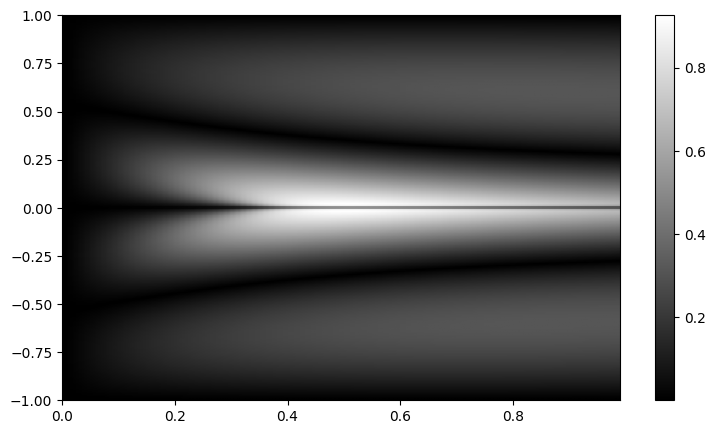

In [ ]:
### FORECAST QUALITY
u_pred, f_pred = model_id.predict(x_star, t_star)
u_pred = u_pred.flatten()

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
print("Error u: %e" % (error_u))

U_pred = griddata(X_star, u_pred, (X, T), method="cubic")
Error = np.abs(Exact - U_pred)
error_u2 = np.linalg.norm(Exact - U_pred, "fro") / np.linalg.norm(U_pred, "fro")
print("Error u: %e" % (error_u2))

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
h = ax.imshow(
    Error.T,
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
    cmap="gray",
)
cbar = fig.colorbar(h)
plt.show()

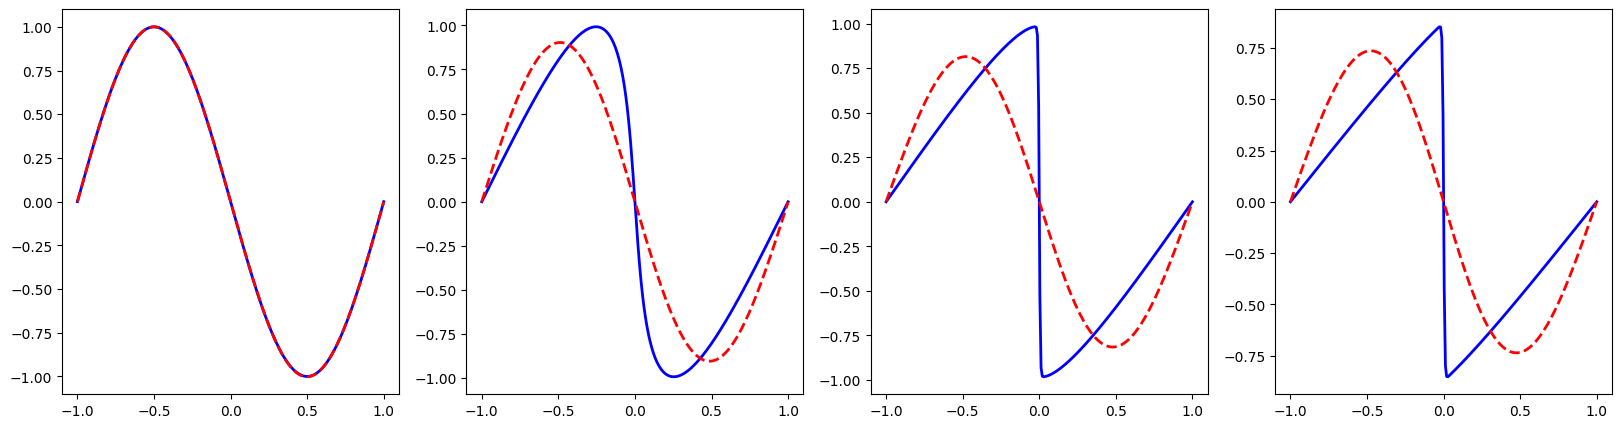

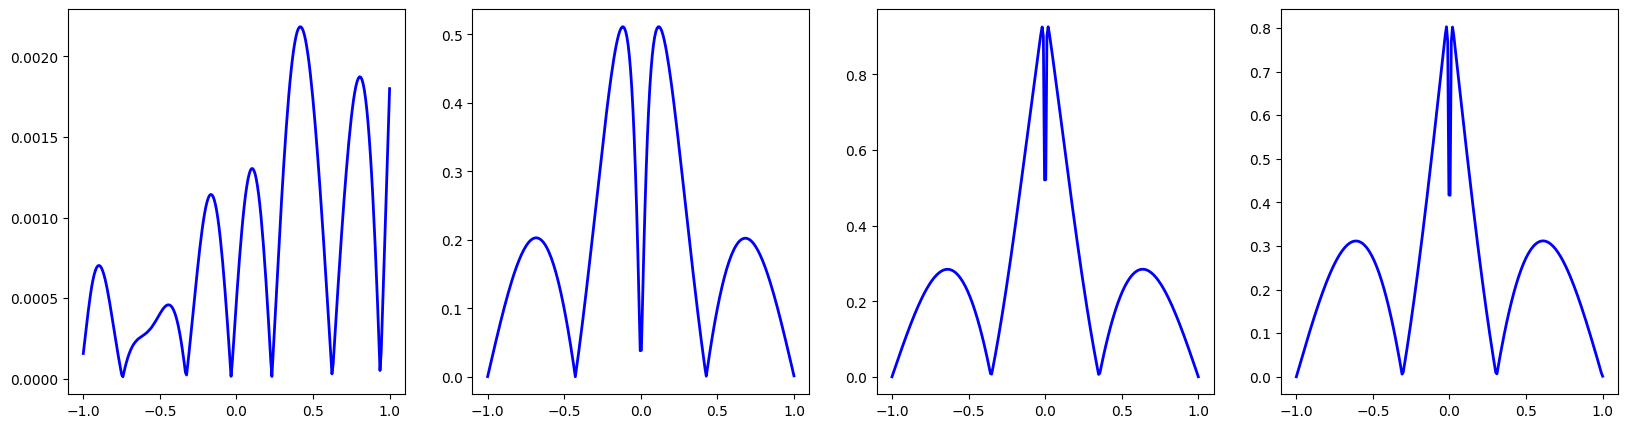

In [ ]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, Exact[0, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[0, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(142)
ax.plot(x, Exact[25, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[25, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(143)
ax.plot(x, Exact[50, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[50, :], "r--", linewidth=2, label="Prediction")


ax = fig.add_subplot(144)
ax.plot(x, Exact[75, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[75, :], "r--", linewidth=2, label="Prediction")

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, Error[0, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(142)
ax.plot(x, Error[25, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(143)
ax.plot(x, Error[50, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(144)
ax.plot(x, Error[75, :], "b-", linewidth=2, label="Erreur")

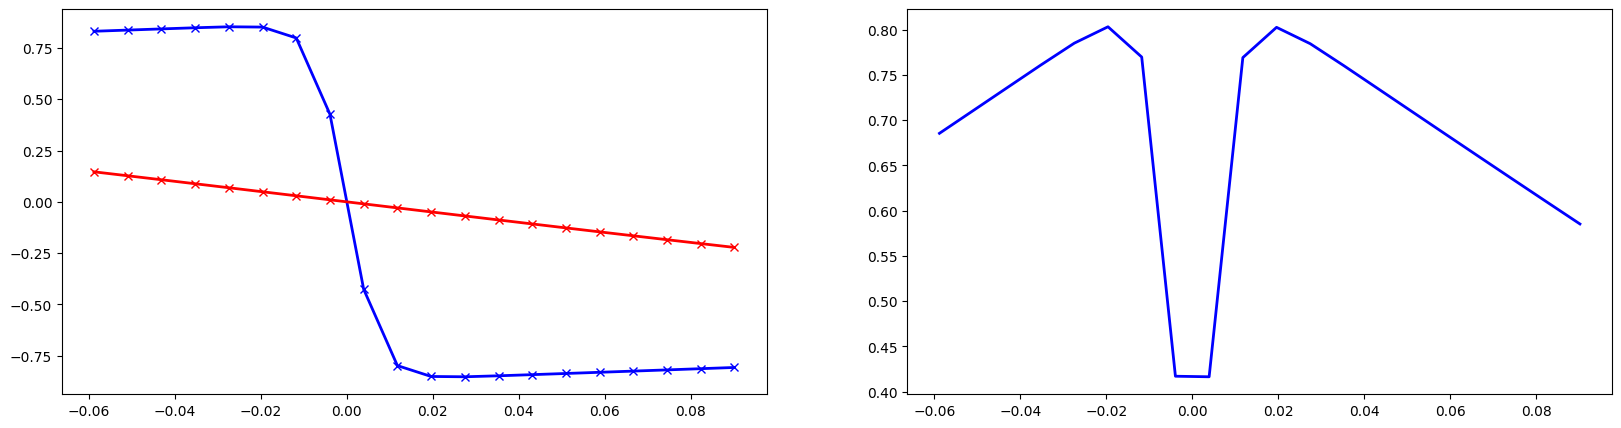

In [ ]:
index = 75
min = 120
max = 140
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(121)
ax.plot(x[min:max], Exact[index, min:max], "b-x", linewidth=2, label="Exact")
ax.plot(x[min:max], U_pred[index, min:max], "r-x", linewidth=2, label="Prediction")

ax = fig.add_subplot(122)
ax.plot(x[min:max], Error[index, min:max], "b-", linewidth=2, label="Exact")